In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from copy import deepcopy

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)
print(torch.__version__)

2.20.0
2.5.0


In [4]:
# Set random seeds for reproducibility
tf.random.set_seed(42)

torch.manual_seed(42)

np.random.seed(42)

In [5]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.5.0


In [6]:
train_df = pd.read_csv('Data/train.csv', index_col=0)
val_df = pd.read_csv('Data/val.csv', index_col=0)
test_df = pd.read_csv('Data/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [7]:
train_df

temp  clouds_all  traffic_volume   day_sin   day_cos
0      0.760019        0.00        0.758755  0.066987  0.250000
1      0.738174        0.00        0.560765  0.017037  0.370590
2      0.698884        0.00        0.463513  0.000000  0.500000
3      0.668238        0.00        0.370029  0.017037  0.629410
4      0.643093        0.00        0.325101  0.066987  0.750000
...         ...         ...             ...       ...       ...
12280  0.422599        0.90        0.599972  0.933013  0.250000
12281  0.421656        0.75        0.561881  0.853553  0.146447
12282  0.436272        0.90        0.567881  0.750000  0.066987
12283  0.439415        0.75        0.644482  0.629410  0.017037
12284  0.443659        0.40        0.652016  0.500000  0.000000

[12285 rows x 5 columns]

In [8]:
# TF
class DataWindowtf():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [9]:
# TF
def compile_and_fittf(model, window, patience=3, max_epochs=50): #  The function takes a model and a window of data from the DataWindow class. The patience is the number of epochs after which the model should stop training if the validation loss does not improve; max_epochs sets a maximum number of epochs to train the model.
    early_stopping = EarlyStopping(monitor='val_loss', # The validation loss is tracked to determine if we should apply early stopping or not.
                                   patience=patience, # Early stopping occurs if 3 consecutive epochs do not decrease the validation loss, as set by the patience parameter.
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(), #  The MSE is used as the loss function.
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()]) # The MAE is used as an error metric. This is how we compare the performance of our models. A lower MAE means a better model.
    
    history = model.fit(window.train, # The model is fit on the training set.
                       epochs=max_epochs, # The model can train for at most 50 epochs, as set by the max_epochs parameter.
                       validation_data=window.val, # We use the validation set to calculate the validation loss.
                       callbacks=[early_stopping]) # early_stopping is passed as a callback. If the validation loss does not decrease after 3 consecutive epochs, the model stops training. This avoids overfitting.
    
    return history

In [10]:
# Pytortch
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length, target_columns=None , stride=1):
        self.data = torch.FloatTensor(data.values if hasattr(data, 'values') else data)
        self.sequence_length = sequence_length
        self.target_columns = target_columns
        self.stride = stride
        
        # Calculate valid starting indices
        self.indices = list(range(0, len(self.data) - sequence_length + 1, stride))
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        start_idx = self.indices[idx]
        sequence = self.data[start_idx:start_idx + self.sequence_length]
        return sequence

class DataWindowpt():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None, batch_size=32):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns # Name of the column that we wish to predict
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}  # Create a dictionary with the name and index of the label column. This will be used for plotting.
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)} # Create a dictionary with the name and index of each column. This will be used to separate the features from the target variable.
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.batch_size = batch_size
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width) # The slice function returns a slice object that specifies how to slice a sequence. In this case, it says that the input slice starts at 0 and ends when we reach the input_width.
        self.input_indices = np.arange(self.total_window_size)[self.input_slice] # Assign indices to the inputs. These are useful for plotting.
        
        self.label_start = self.total_window_size - self.label_width # Get the index at which the label starts. In this case, it is the total window size minus the width of the label.
        self.labels_slice = slice(self.label_start, None) # The same steps that were applied for the inputs are applied for labels.
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :] # Slice the window to get the inputs using the input_slice defined in __init__.
        labels = features[:, self.labels_slice, :] # Slice the window to get the labels using the labels_slice defined in __init__.
        
        if self.label_columns is not None: # if we have more than one target, we stack the labels.
            label_indices = [self.column_indices[name] for name in self.label_columns]
            labels = labels[:, :, label_indices]
            
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index].detach().numpy(),
                     label='Inputs', marker='.', zorder=-10) # Plot the inputs. They will appear as a continuous blue line with dots.

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index].detach().numpy(),
                        edgecolors='k', marker='s', label='Labels', c='green', s=64) # Plot the labels or actual values. They will appear as green squares.
            
            if model is not None:
                with torch.no_grad():
                    predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index].detach().numpy(),
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64) #  Plot the predictions. They will appear as red crosses.

            if n == 0:
                plt.legend()

        plt.xlabel('Time (h)')
    
    def make_dataset(self, data):
        dataset = TimeSeriesDataset(data, self.total_window_size, stride=1)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Create a mapped dataloader
        def mapped_dataloader():
            for batch in dataloader:
                yield self.split_to_inputs_labels(batch)
        
        return mapped_dataloader()
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [11]:
# Evaluation function pytorch
def evaluate_model(model, dataloader, verbose=0):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0
    total_mae = 0
    num_batches = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            mae = torch.mean(torch.abs(predictions - labels))
            
            total_loss += loss.item()
            total_mae += mae.item()
            num_batches += 1
    
    avg_loss = total_loss / num_batches
    avg_mae = total_mae / num_batches
    
    if verbose > 0:
        print(f'Loss: {avg_loss:.4f} - MAE: {avg_mae:.4f}')
    
    return avg_loss, avg_mae

In [12]:
# PT
# Early stopping class
class EarlyStoppingpt:
    def __init__(self, patience=3, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = deepcopy(model.state_dict())

In [114]:
# PT
# Training function
def compile_and_fitpt(model, window, patience=3, max_epochs=50, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    early_stopping = EarlyStoppingpt(patience=patience)
    
    train_losses = []
    val_losses = []
    train_maes = []
    val_maes = []
    
    for epoch in range(max_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        total_train_mae = 0
        train_batches = 0
        
        for inputs, labels in window.train:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            total_train_mae += torch.mean(torch.abs(outputs - labels)).item()
            train_batches += 1
        
        avg_train_loss = total_train_loss / train_batches
        avg_train_mae = total_train_mae / train_batches
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        total_val_mae = 0
        val_batches = 0
        
        with torch.no_grad():
            for inputs, labels in window.val:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                total_val_loss += loss.item()
                total_val_mae += torch.mean(torch.abs(outputs - labels)).item()
                val_batches += 1
        
        avg_val_loss = total_val_loss / val_batches
        avg_val_mae = total_val_mae / val_batches
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_maes.append(avg_train_mae)
        val_maes.append(avg_val_mae)
        
        print(f'Epoch {epoch+1}/{max_epochs} - '
              f'loss: {avg_train_loss:.4f} - mae: {avg_train_mae:.4f} - '
              f'val_loss: {avg_val_loss:.4f} - val_mae: {avg_val_mae:.4f}')
        
        if early_stopping(avg_val_loss, model):
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # Return history-like object
    history = {
        'loss': train_losses,
        'val_loss': val_losses,
        'mae': train_maes,
        'val_mae': val_maes
    }
    
    return history

# CNN

## Single-step model

In [14]:
# TF
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

conv_window = DataWindowtf(input_width=KERNEL_WIDTH, label_width=1, shift=1, label_columns=['traffic_volume'])
wide_conv_window = DataWindowtf(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['traffic_volume'])

In [15]:
# Values obtained from 14

mae_val = [0.083, 0.068, 0.033, 0.03]
mae_test = [0.081, 0.068, 0.029, 0.026]

In [16]:
# TF
cnn_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

# TensorFlow Conv1D:
# -Default format: (batch, steps, channels) - called "channels_last" or NWC
# -Input shape: (batch_size, sequence_length, features)
# -No transpose needed because this matches how time series data is naturally organized

# -Keras automatically handles the shape transitions between layers:
# -Conv1D output: (batch_size, sequence_length, filters)
# --For input (batch, 3, 5) with 32 filters → output (batch, 1, 32)
# -Dense layer: Keras automatically flattens the Conv1D output internally
# --The Dense layer sees the last dimension (32) and creates connections accordingly
# -Sequential model: Handles all shape inference behind the scenes

history = compile_and_fittf(cnn_model, conv_window)

val_performance = {}
performance = {}

val_performance['CNN-TF'] = cnn_model.evaluate(conv_window.val)
performance['CNN-TF'] = cnn_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0207 - mean_absolute_error: 0.0966 - val_loss: 0.0074 - val_mean_absolute_error: 0.0628
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056 - mean_absolute_error: 0.0558 - val_loss: 0.0045 - val_mean_absolute_error: 0.0517
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0042 - mean_absolute_error: 0.0476 - val_loss: 0.0042 - val_mean_absolute_error: 0.0499
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0035 - mean_absolute_error: 0.0429 - val_loss: 0.0026 - val_mean_absolute_error: 0.0373
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032 - mean_absolute_error: 0.0404 - val_loss: 0.0024 - val_mean_absolute_error: 0.0368
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0029 - mean_absolute_error: 0.0383 - val_loss: 0.0022 - val_mean_absolute_error: 0.0345
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0027 - mean_absolute_error: 0.0367 - v

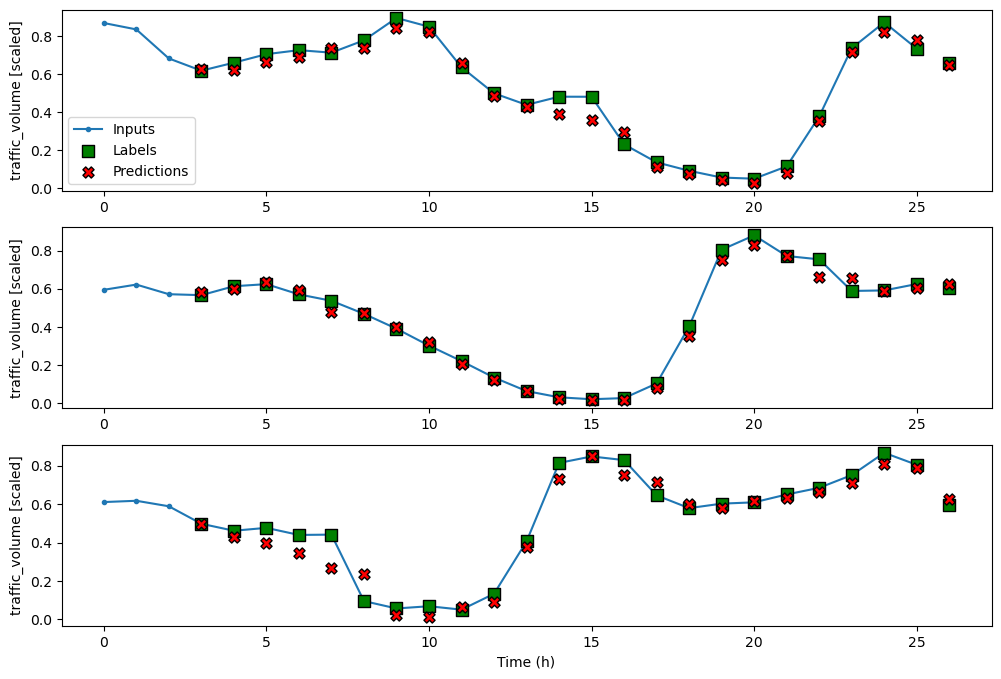

In [17]:
wide_conv_window.plot(cnn_model) # For some reason this doesnt seem to produce an error reliting to input size

In [110]:
# PT
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

conv_window = DataWindowpt(input_width=KERNEL_WIDTH, label_width=1, shift=1, label_columns=['traffic_volume'])
wide_conv_window = DataWindowpt(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['traffic_volume'])

In [120]:
# PT
class CNNModel(nn.Module):
    def __init__(self, input_channels, kernel_size=3, filters=32, dense_units=32, output_size=1):
        super(CNNModel, self).__init__()
        self.conv1d = nn.Conv1d(input_channels, filters, kernel_size)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
        # Calculate the size after convolution
        # For Conv1D: output_size = (input_size - kernel_size) + 1
        # We need to calculate this based on input_width
        self.dense1 = nn.LazyLinear(dense_units)
        self.dense2 = nn.Linear(dense_units, output_size)
        self.output_size = output_size
    
    def forward(self, x):
        # x shape: (batch, seq_len, features) -> need (batch, features, seq_len) for Conv1D
        x = x.transpose(1, 2)
        # PyTorch Conv1D:
        # -Required format: (batch, channels, length) - called "channels_first" or NCW
        # -Input shape: (batch_size, features, sequence_length)
        # -Transpose needed to convert from natural time series format
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        if self.output_size > 1:
            x = x.unsqueeze(1)
            return x
        x = x.unsqueeze(2) # Add sequence dimension for consistency
        return x  

In [99]:
# PT
input_size = len(train_df.columns)
cnn_model = CNNModel(input_channels=input_size, kernel_size=KERNEL_WIDTH)

history = compile_and_fitpt(cnn_model, conv_window)

val_performance['CNN-PT'] = evaluate_model(cnn_model, conv_window.val)
performance['CNN-PT'] = evaluate_model(cnn_model, conv_window.test)

tensor([[[0.7484, 0.0500, 0.6686, 0.9330, 0.2500],
         [0.7850, 0.0500, 0.6153, 0.8536, 0.1464],
         [0.8114, 0.0100, 0.6265, 0.7500, 0.0670]],

        [[0.8312, 0.0100, 0.8278, 0.0670, 0.2500],
         [0.8259, 0.0100, 0.6266, 0.0170, 0.3706],
         [0.8010, 0.0500, 0.5082, 0.0000, 0.5000]],

        [[0.3347, 0.0100, 0.4122, 0.9330, 0.7500],
         [0.3322, 0.0100, 0.7488, 0.9830, 0.6294],
         [0.3286, 0.0500, 0.7175, 1.0000, 0.5000]],

        [[0.3322, 0.0100, 0.7906, 0.9830, 0.3706],
         [0.3410, 0.0100, 0.6658, 0.9330, 0.2500],
         [0.3619, 0.0100, 0.5728, 0.8536, 0.1464]],

        [[0.4823, 0.0500, 0.4512, 0.7500, 0.0670],
         [0.5127, 0.0500, 0.4264, 0.6294, 0.0170],
         [0.5409, 0.0500, 0.4097, 0.5000, 0.0000]],

        [[0.6910, 0.0000, 0.6065, 0.0670, 0.2500],
         [0.6443, 0.4400, 0.5291, 0.0170, 0.3706],
         [0.6443, 0.4400, 0.4851, 0.0000, 0.5000]],

        [[0.5662, 0.7500, 0.8319, 0.9830, 0.3706],
         [0.5703, 0

C:\Users\ASUS\miniconda3\envs\DataVis\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 1, 2])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[[0.3640, 0.1458]],

        [[0.5746, 0.3519]],

        [[0.5505, 0.7649]],

        [[0.4415, 0.1838]],

        [[0.3322, 0.6953]],

        [[0.7328, 0.5700]],

        [[0.1095, 0.0265]],

        [[0.7746, 0.5898]],

        [[0.5768, 0.0966]],

        [[0.5969, 0.7991]],

        [[0.4657, 0.0996]],

        [[0.4006, 0.7057]],

        [[0.1220, 0.0207]],

        [[0.6425, 0.6436]],

        [[0.4217, 0.0527]],

        [[0.7929, 0.0218]],

        [[0.3093, 0.3566]],

        [[0.4903, 0.9537]],

        [[0.5021, 0.3910]],

        [[0.8920, 0.3781]],

        [[0.6352, 0.3552]],

        [[0.4476, 0.2354]],

        [[0.4432, 0.0297]],

        [[0.4844, 0.8662]],

        [[0.1806, 0.1206]],

        [[0.7368, 0.5320]],

        [[0.6618, 0.6362]],

        [[0.6296, 0.6227]],

        [[0.3429, 0.7338]],

        [[0.5823, 0.8935]],

        [[0.3948, 0.6372]],

        [[0.6113, 0.6510]]])
torch.Size([32, 3, 5])
^^^^^^^^^^^^^^^^^^^^
torch.Size([32, 5, 3])
-----

C:\Users\ASUS\miniconda3\envs\DataVis\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([26, 1, 2])) that is different to the input size (torch.Size([26, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\ASUS\miniconda3\envs\DataVis\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([19, 1, 2])) that is different to the input size (torch.Size([19, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([32, 3, 5])
^^^^^^^^^^^^^^^^^^^^
torch.Size([32, 5, 3])
--------------
torch.Size([32, 32, 1])
torch.Size([32, 32, 1])
+++++++++++++++++
torch.Size([32, 32])
%%%%%%%%%%%%%%%%%
torch.Size([32, 32])
#################
torch.Size([32, 32])
*****************
torch.Size([32, 1])
&&&&&&&&&&&&&&&&&&
torch.Size([32, 1, 1])
done
torch.Size([32, 3, 5])
^^^^^^^^^^^^^^^^^^^^
torch.Size([32, 5, 3])
--------------
torch.Size([32, 32, 1])
torch.Size([32, 32, 1])
+++++++++++++++++
torch.Size([32, 32])
%%%%%%%%%%%%%%%%%
torch.Size([32, 32])
#################
torch.Size([32, 32])
*****************
torch.Size([32, 1])
&&&&&&&&&&&&&&&&&&
torch.Size([32, 1, 1])
done
torch.Size([32, 3, 5])
^^^^^^^^^^^^^^^^^^^^
torch.Size([32, 5, 3])
--------------
torch.Size([32, 32, 1])
torch.Size([32, 32, 1])
+++++++++++++++++
torch.Size([32, 32])
%%%%%%%%%%%%%%%%%
torch.Size([32, 32])
#################
torch.Size([32, 32])
*****************
torch.Size([32, 1])
&&&&&&&&&&&&&&&&&&
torch.Size([32, 1, 1])
done
torc

C:\Users\ASUS\miniconda3\envs\DataVis\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([25, 1, 2])) that is different to the input size (torch.Size([25, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### CNN + LSTM

In [21]:
# TF
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

conv_window = DataWindowtf(input_width=KERNEL_WIDTH, label_width=1, shift=1, label_columns=['traffic_volume'])
wide_conv_window = DataWindowtf(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['traffic_volume'])

In [22]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fittf(cnn_lstm_model, conv_window)

val_performance['CNN + LSTM-TF'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN + LSTM-TF'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0331 - mean_absolute_error: 0.1204 - val_loss: 0.0073 - val_mean_absolute_error: 0.0659
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0064 - mean_absolute_error: 0.0582 - val_loss: 0.0047 - val_mean_absolute_error: 0.0502
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050 - mean_absolute_error: 0.0517 - val_loss: 0.0038 - val_mean_absolute_error: 0.0450
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0042 - mean_absolute_error: 0.0472 - val_loss: 0.0046 - val_mean_absolute_error: 0.0531
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0039 - mean_absolute_error: 0.0454 - val_loss: 0.0033 - val_mean_absolute_error: 0.0434
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0037 - mean_absolute_error: 0.0443 - val_loss: 0.0030 - val_mean_absolute_error: 0.0400
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033 - mean_absolute_error: 0.0415 - v

In [23]:
# PT
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

conv_window = DataWindowpt(input_width=KERNEL_WIDTH, label_width=1, shift=1, label_columns=['traffic_volume'])
wide_conv_window = DataWindowpt(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['traffic_volume'])

In [24]:
#PT
# CNN + LSTM Model
class CNNLSTMModel(nn.Module):
    def __init__(self, input_channels, kernel_size=3, filters=32, lstm_units=32, output_size=1, return_sequences=True):
        super(CNNLSTMModel, self).__init__()
        self.conv1d = nn.Conv1d(input_channels, filters, kernel_size)
        self.relu = nn.ReLU()
        self.lstm1 = nn.LSTM(filters, lstm_units, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_units, lstm_units, batch_first=True)
        self.dense = nn.Linear(lstm_units, output_size)
        self.return_sequences = return_sequences
    
    def forward(self, x):
        # x shape: (batch, seq_len, features) -> need (batch, features, seq_len) for Conv1D
        batch_size, seq_len, features = x.shape
        x = x.transpose(1, 2)
        x = self.conv1d(x)
        x = self.relu(x)
        
        # Transpose back for LSTM: (batch, seq_len, features)
        x = x.transpose(1, 2)
        
        # LSTM layers
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        
        if self.return_sequences:
            # Apply dense to each timestep
            x = self.dense(x)
        else:
            # Only use the last timestep
            x = self.dense(x[:, -1, :])
            x = x.unsqueeze(1)
        
        return x

In [25]:
# PT
input_size = len(train_df.columns)
cnn_lstm_model = CNNModel(input_channels=input_size, kernel_size=KERNEL_WIDTH)

history = compile_and_fitpt(cnn_lstm_model, conv_window)

val_performance['CNN + LSTM-PT'] = evaluate_model(cnn_lstm_model, conv_window.val)
performance['CNN + LSTM-PT'] = evaluate_model(cnn_lstm_model, conv_window.test)

Epoch 1/50 - loss: 0.0231 - mae: 0.1008 - val_loss: 0.0062 - val_mae: 0.0608
Epoch 2/50 - loss: 0.0052 - mae: 0.0533 - val_loss: 0.0040 - val_mae: 0.0491
Epoch 3/50 - loss: 0.0039 - mae: 0.0457 - val_loss: 0.0028 - val_mae: 0.0388
Epoch 4/50 - loss: 0.0033 - mae: 0.0415 - val_loss: 0.0029 - val_mae: 0.0404
Epoch 5/50 - loss: 0.0031 - mae: 0.0395 - val_loss: 0.0026 - val_mae: 0.0385
Epoch 6/50 - loss: 0.0030 - mae: 0.0390 - val_loss: 0.0025 - val_mae: 0.0362
Epoch 7/50 - loss: 0.0028 - mae: 0.0369 - val_loss: 0.0029 - val_mae: 0.0401
Epoch 8/50 - loss: 0.0027 - mae: 0.0364 - val_loss: 0.0028 - val_mae: 0.0397
Epoch 9/50 - loss: 0.0027 - mae: 0.0369 - val_loss: 0.0020 - val_mae: 0.0319
Epoch 10/50 - loss: 0.0026 - mae: 0.0363 - val_loss: 0.0020 - val_mae: 0.0319
Epoch 11/50 - loss: 0.0026 - mae: 0.0355 - val_loss: 0.0019 - val_mae: 0.0317
Epoch 12/50 - loss: 0.0025 - mae: 0.0348 - val_loss: 0.0018 - val_mae: 0.0298
Epoch 13/50 - loss: 0.0024 - mae: 0.0341 - val_loss: 0.0025 - val_mae: 0.

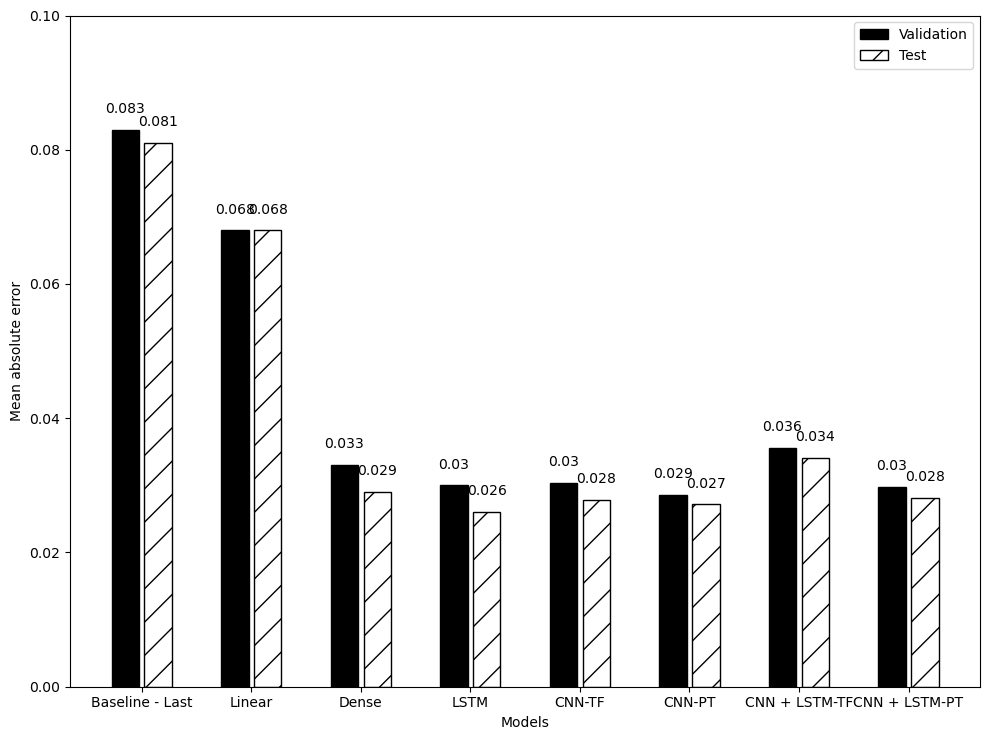

In [26]:
mae_val.extend([v[1] for v in val_performance.values()])
mae_test.extend([v[1] for v in performance.values()])

x = np.arange(8)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN-TF', 'CNN-PT', 'CNN + LSTM-TF', 'CNN + LSTM-PT']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

## Multi-step model

In [40]:
#TF
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_window = DataWindowtf(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['traffic_volume'])

In [61]:
# Values obtained from 14

ms_mae_val = [0.352, 0.347, 0.088, 0.078, 0.070]
ms_mae_test = [0.347, 0.341, 0.076, 0.064, 0.058]

In [42]:
ms_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fittf(ms_cnn_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['CNN-TF'] = ms_cnn_model.evaluate(multi_window.val)
ms_performance['CNN-TF'] = ms_cnn_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0338 - mean_absolute_error: 0.1212 - val_loss: 0.0157 - val_mean_absolute_error: 0.0830
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0136 - mean_absolute_error: 0.0777 - val_loss: 0.0149 - val_mean_absolute_error: 0.0826
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0132 - mean_absolute_error: 0.0767 - val_loss: 0.0149 - val_mean_absolute_error: 0.0799
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0130 - mean_absolute_error: 0.0762 - val_loss: 0.0145 - val_mean_absolute_error: 0.0853
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0758 - val_loss: 0.0143 - val_mean_absolute_error: 0.0849
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0127 - mean_absolute_error: 0.0752 - val_loss: 0.0136 - val_mean_absolute_error: 0.0792
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0125 - mean_absolute_error: 0.0746 - v

In [43]:
# PT
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_window = DataWindowpt(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['traffic_volume'])

In [44]:
# PT
input_size = len(train_df.columns)
ms_cnn_model = CNNModel(input_channels=input_size, kernel_size=KERNEL_WIDTH, output_size=LABEL_WIDTH)

history = compile_and_fitpt(ms_cnn_model, multi_window)

ms_val_performance['CNN-PT'] = evaluate_model(ms_cnn_model, multi_window.val)
ms_performance['CNN-PT'] = evaluate_model(ms_cnn_model, multi_window.test)

Epoch 1/50 - loss: 0.0287 - mae: 0.1182 - val_loss: 0.0165 - val_mae: 0.0905
Epoch 2/50 - loss: 0.0134 - mae: 0.0813 - val_loss: 0.0143 - val_mae: 0.0805
Epoch 3/50 - loss: 0.0118 - mae: 0.0745 - val_loss: 0.0129 - val_mae: 0.0743
Epoch 4/50 - loss: 0.0108 - mae: 0.0707 - val_loss: 0.0119 - val_mae: 0.0720
Epoch 5/50 - loss: 0.0102 - mae: 0.0682 - val_loss: 0.0119 - val_mae: 0.0703
Epoch 6/50 - loss: 0.0098 - mae: 0.0663 - val_loss: 0.0110 - val_mae: 0.0671
Epoch 7/50 - loss: 0.0095 - mae: 0.0653 - val_loss: 0.0110 - val_mae: 0.0670
Epoch 8/50 - loss: 0.0092 - mae: 0.0641 - val_loss: 0.0106 - val_mae: 0.0659
Epoch 9/50 - loss: 0.0090 - mae: 0.0632 - val_loss: 0.0104 - val_mae: 0.0646
Epoch 10/50 - loss: 0.0087 - mae: 0.0624 - val_loss: 0.0102 - val_mae: 0.0662
Epoch 11/50 - loss: 0.0086 - mae: 0.0617 - val_loss: 0.0100 - val_mae: 0.0632
Epoch 12/50 - loss: 0.0084 - mae: 0.0611 - val_loss: 0.0101 - val_mae: 0.0640
Epoch 13/50 - loss: 0.0082 - mae: 0.0602 - val_loss: 0.0098 - val_mae: 0.

## CNN + LSTM

In [45]:
#TF
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_window = DataWindowtf(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['traffic_volume'])

In [46]:
ms_cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fittf(ms_cnn_lstm_model, multi_window)

ms_val_performance['CNN + LSTM-TF'] = ms_cnn_lstm_model.evaluate(multi_window.val)
ms_performance['CNN + LSTM-TF'] = ms_cnn_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0359 - mean_absolute_error: 0.1290 - val_loss: 0.0163 - val_mean_absolute_error: 0.0847
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0140 - mean_absolute_error: 0.0791 - val_loss: 0.0154 - val_mean_absolute_error: 0.0812
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0134 - mean_absolute_error: 0.0765 - val_loss: 0.0148 - val_mean_absolute_error: 0.0798
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0130 - mean_absolute_error: 0.0747 - val_loss: 0.0143 - val_mean_absolute_error: 0.0784
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0126 - mean_absolute_error: 0.0734 - val_loss: 0.0139 - val_mean_absolute_error: 0.0784
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0123 - mean_absolute_error: 0.0723 - val_loss: 0.0138 - val_mean_absolute_error: 0.0796
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0120 - mean_absolute_error: 0.0710 - v

In [47]:
# PT
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_window = DataWindowpt(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['traffic_volume'])

In [48]:
#PT
# Multi-step CNN + LSTM Model
class MultiStepCNNLSTMModel(nn.Module):
    def __init__(self, input_channels, kernel_size=3, filters=32, lstm_units=32, output_steps=24, output_size=1):
        super(MultiStepCNNLSTMModel, self).__init__()
        self.conv1d = nn.Conv1d(input_channels, filters, kernel_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(filters, lstm_units, batch_first=True)
        self.dense = nn.Linear(lstm_units, output_size)
        self.output_steps = output_steps
    
    def forward(self, x):
        batch_size, seq_len, features = x.shape
        x = x.transpose(1, 2)
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.transpose(1, 2)
        
        x, _ = self.lstm(x)
        
        # Apply dense layer to get multi-step output
        # Repeat the last hidden state for multiple time steps
        last_hidden = x[:, -1:, :].repeat(1, self.output_steps, 1)
        x = self.dense(last_hidden)
        
        return x

In [49]:
# PT
input_size = len(train_df.columns)
ms_cnn_lstm_model = CNNModel(input_channels=input_size, kernel_size=KERNEL_WIDTH, output_size=LABEL_WIDTH)

history = compile_and_fitpt(ms_cnn_lstm_model, multi_window)

ms_val_performance['CNN + LSTM-PT'] = evaluate_model(ms_cnn_lstm_model, multi_window.val)
ms_performance['CNN + LSTM-PT'] = evaluate_model(ms_cnn_lstm_model, multi_window.test)

Epoch 1/50 - loss: 0.0279 - mae: 0.1193 - val_loss: 0.0165 - val_mae: 0.0898
Epoch 2/50 - loss: 0.0140 - mae: 0.0827 - val_loss: 0.0145 - val_mae: 0.0825
Epoch 3/50 - loss: 0.0125 - mae: 0.0770 - val_loss: 0.0137 - val_mae: 0.0790
Epoch 4/50 - loss: 0.0116 - mae: 0.0740 - val_loss: 0.0128 - val_mae: 0.0751
Epoch 5/50 - loss: 0.0110 - mae: 0.0713 - val_loss: 0.0122 - val_mae: 0.0749
Epoch 6/50 - loss: 0.0105 - mae: 0.0694 - val_loss: 0.0118 - val_mae: 0.0711
Epoch 7/50 - loss: 0.0101 - mae: 0.0678 - val_loss: 0.0113 - val_mae: 0.0711
Epoch 8/50 - loss: 0.0097 - mae: 0.0662 - val_loss: 0.0111 - val_mae: 0.0707
Epoch 9/50 - loss: 0.0095 - mae: 0.0651 - val_loss: 0.0109 - val_mae: 0.0671
Epoch 10/50 - loss: 0.0092 - mae: 0.0640 - val_loss: 0.0100 - val_mae: 0.0649
Epoch 11/50 - loss: 0.0090 - mae: 0.0631 - val_loss: 0.0099 - val_mae: 0.0639
Epoch 12/50 - loss: 0.0087 - mae: 0.0622 - val_loss: 0.0097 - val_mae: 0.0643
Epoch 13/50 - loss: 0.0086 - mae: 0.0620 - val_loss: 0.0096 - val_mae: 0.

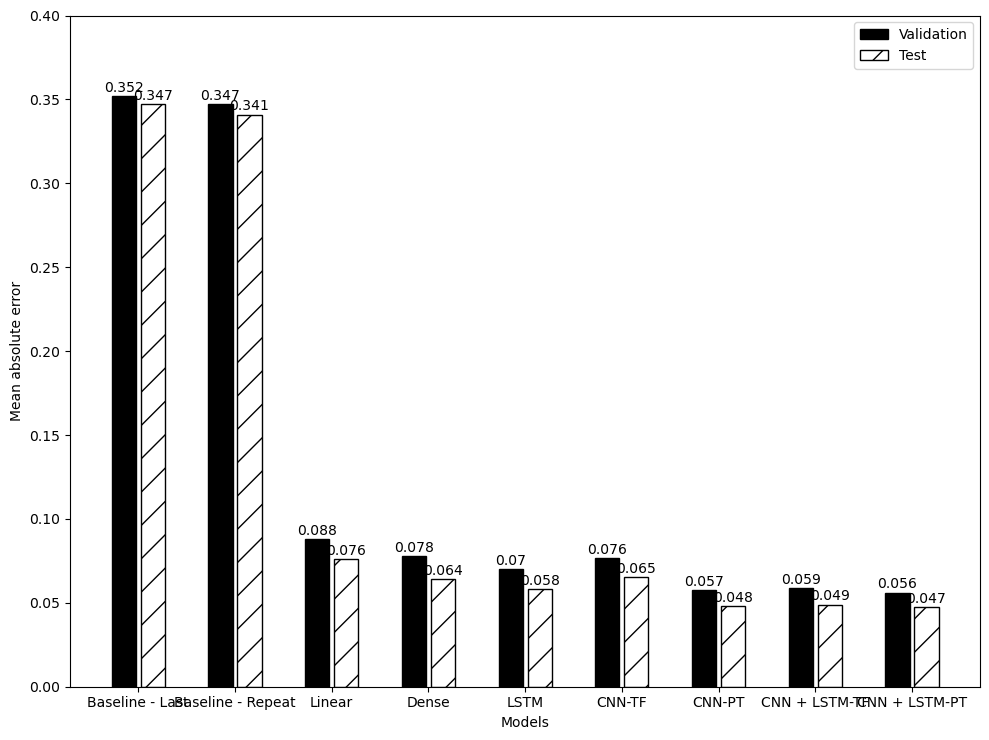

In [62]:
ms_mae_val.extend([v[1] for v in ms_val_performance.values()])
ms_mae_test.extend([v[1] for v in ms_performance.values()])

x = np.arange(9)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN-TF', 'CNN-PT', 'CNN + LSTM-TF', 'CNN + LSTM-PT']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

## Multi-output model

In [63]:
#TF
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_mo_conv_window = DataWindowtf(input_width=INPUT_WIDTH, label_width=24, shift=1, label_columns=['temp', 'traffic_volume'])

In [64]:
# Values from 14

mo_mae_val = [0.048, 0.039, 0.023, 0.020]
mo_mae_test = [0.047, 0.036, 0.020, 0.017]

In [65]:
# TF
mo_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2)
])

history = compile_and_fittf(mo_cnn_model, wide_mo_conv_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['CNN-TF'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN-TF'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0267 - mean_absolute_error: 0.0923 - val_loss: 0.0034 - val_mean_absolute_error: 0.0383
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0029 - mean_absolute_error: 0.0352 - val_loss: 0.0022 - val_mean_absolute_error: 0.0316
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0022 - mean_absolute_error: 0.0308 - val_loss: 0.0017 - val_mean_absolute_error: 0.0281
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0018 - mean_absolute_error: 0.0277 - val_loss: 0.0014 - val_mean_absolute_error: 0.0249
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0255 - val_loss: 0.0013 - val_mean_absolute_error: 0.0238
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0015 - mean_absolute_error: 0.0244 - val_loss: 0.0011 - val_mean_absolute_error: 0.0220
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0232 - v

In [121]:
# PT
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_mo_conv_window = DataWindowpt(input_width=INPUT_WIDTH, label_width=1, shift=1, label_columns=['temp', 'traffic_volume'])

In [122]:
# PT
input_size = len(train_df.columns)
mo_cnn_model = CNNModel(input_channels=input_size, kernel_size=KERNEL_WIDTH, output_size=2)

history = compile_and_fitpt(mo_cnn_model, wide_mo_conv_window)

mo_val_performance['CNN-PT'] = evaluate_model(mo_cnn_model, wide_mo_conv_window.val)
mo_performance['CNN-PT'] = evaluate_model(mo_cnn_model, wide_mo_conv_window.test)

Epoch 1/50 - loss: 0.0142 - mae: 0.0751 - val_loss: 0.0056 - val_mae: 0.0476
Epoch 2/50 - loss: 0.0045 - mae: 0.0443 - val_loss: 0.0034 - val_mae: 0.0393
Epoch 3/50 - loss: 0.0031 - mae: 0.0374 - val_loss: 0.0025 - val_mae: 0.0352
Epoch 4/50 - loss: 0.0026 - mae: 0.0344 - val_loss: 0.0022 - val_mae: 0.0329
Epoch 5/50 - loss: 0.0021 - mae: 0.0311 - val_loss: 0.0018 - val_mae: 0.0290
Epoch 6/50 - loss: 0.0019 - mae: 0.0298 - val_loss: 0.0016 - val_mae: 0.0280
Epoch 7/50 - loss: 0.0019 - mae: 0.0292 - val_loss: 0.0018 - val_mae: 0.0306
Epoch 8/50 - loss: 0.0017 - mae: 0.0278 - val_loss: 0.0014 - val_mae: 0.0279
Epoch 9/50 - loss: 0.0016 - mae: 0.0273 - val_loss: 0.0012 - val_mae: 0.0243
Epoch 10/50 - loss: 0.0015 - mae: 0.0262 - val_loss: 0.0011 - val_mae: 0.0224
Epoch 11/50 - loss: 0.0015 - mae: 0.0261 - val_loss: 0.0016 - val_mae: 0.0309
Epoch 12/50 - loss: 0.0015 - mae: 0.0254 - val_loss: 0.0012 - val_mae: 0.0241
Epoch 13/50 - loss: 0.0014 - mae: 0.0249 - val_loss: 0.0012 - val_mae: 0.

### CNN + LSTM

In [126]:
#TF
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_mo_conv_window = DataWindowtf(input_width=INPUT_WIDTH, label_width=24, shift=1, label_columns=['temp', 'traffic_volume'])

In [127]:
#TF
mo_cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    Dense(units=2)
])

history = compile_and_fittf(mo_cnn_lstm_model, wide_mo_conv_window)

mo_val_performance['CNN + LSTM-TF'] = mo_cnn_lstm_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN + LSTM-TF'] = mo_cnn_lstm_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0183 - mean_absolute_error: 0.0836 - val_loss: 0.0035 - val_mean_absolute_error: 0.0415
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0026 - mean_absolute_error: 0.0349 - val_loss: 0.0019 - val_mean_absolute_error: 0.0304
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0020 - mean_absolute_error: 0.0300 - val_loss: 0.0016 - val_mean_absolute_error: 0.0279
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0018 - mean_absolute_error: 0.0279 - val_loss: 0.0014 - val_mean_absolute_error: 0.0256
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0263 - val_loss: 0.0013 - val_mean_absolute_error: 0.0241
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0015 - mean_absolute_error: 0.0251 - val_loss: 0.0012 - val_mean_absolute_error: 0.0239
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0015 - mean_absolute_error: 0.0242 - v

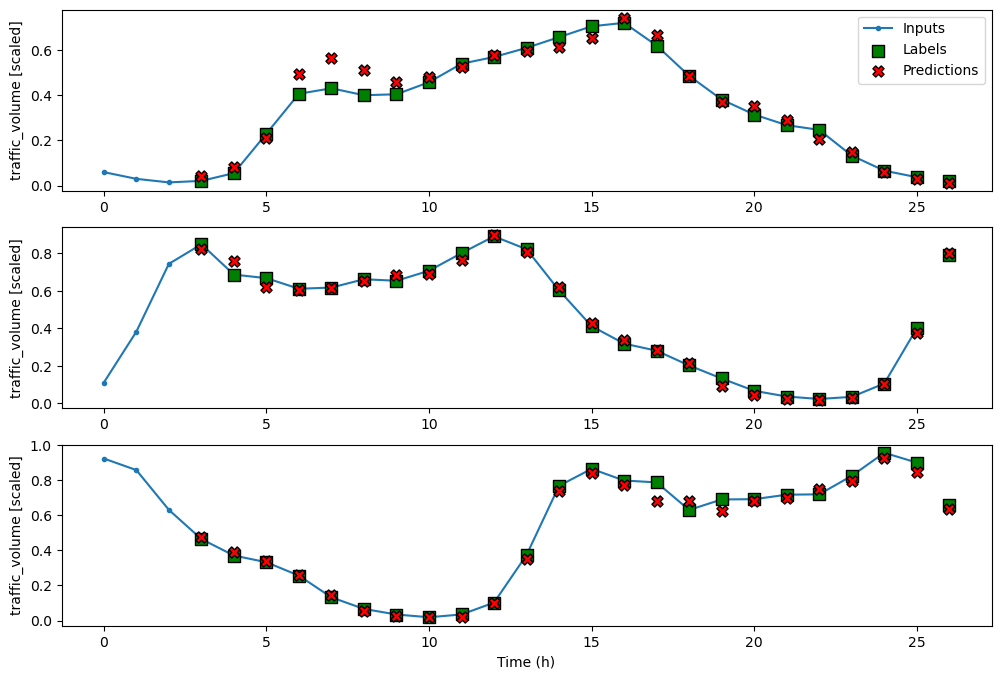

In [128]:
# TF
wide_mo_conv_window.plot(mo_cnn_lstm_model)

In [130]:
#PT
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_mo_conv_window = DataWindowpt(input_width=INPUT_WIDTH, label_width=24, shift=1, label_columns=['temp', 'traffic_volume'])

In [131]:
# PT
input_size = len(train_df.columns)
mo_cnn_lstm_model = CNNLSTMModel(input_channels=input_size, kernel_size=KERNEL_WIDTH, output_size=2, return_sequences=True)

history = compile_and_fitpt(mo_cnn_lstm_model, wide_mo_conv_window)

mo_val_performance['CNN + LSTM-PT'] = evaluate_model(mo_cnn_lstm_model, wide_mo_conv_window.val)
mo_performance['CNN + LSTM-PT'] = evaluate_model(mo_cnn_lstm_model, wide_mo_conv_window.test)

Epoch 1/50 - loss: 0.0351 - mae: 0.1148 - val_loss: 0.0044 - val_mae: 0.0446
Epoch 2/50 - loss: 0.0026 - mae: 0.0339 - val_loss: 0.0018 - val_mae: 0.0290
Epoch 3/50 - loss: 0.0019 - mae: 0.0284 - val_loss: 0.0015 - val_mae: 0.0262
Epoch 4/50 - loss: 0.0016 - mae: 0.0259 - val_loss: 0.0013 - val_mae: 0.0243
Epoch 5/50 - loss: 0.0015 - mae: 0.0241 - val_loss: 0.0012 - val_mae: 0.0240
Epoch 6/50 - loss: 0.0014 - mae: 0.0230 - val_loss: 0.0012 - val_mae: 0.0237
Epoch 7/50 - loss: 0.0013 - mae: 0.0222 - val_loss: 0.0012 - val_mae: 0.0246
Epoch 8/50 - loss: 0.0013 - mae: 0.0218 - val_loss: 0.0011 - val_mae: 0.0222
Epoch 9/50 - loss: 0.0012 - mae: 0.0212 - val_loss: 0.0013 - val_mae: 0.0241
Epoch 10/50 - loss: 0.0012 - mae: 0.0208 - val_loss: 0.0010 - val_mae: 0.0216
Epoch 11/50 - loss: 0.0012 - mae: 0.0205 - val_loss: 0.0010 - val_mae: 0.0208
Epoch 12/50 - loss: 0.0011 - mae: 0.0202 - val_loss: 0.0009 - val_mae: 0.0191
Epoch 13/50 - loss: 0.0011 - mae: 0.0200 - val_loss: 0.0009 - val_mae: 0.

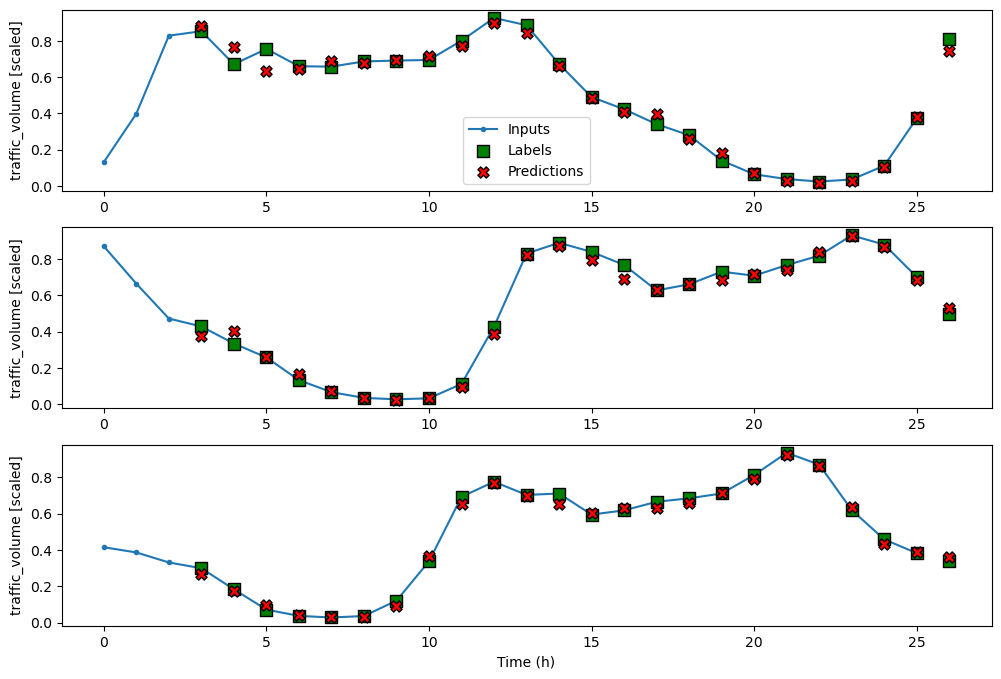

In [132]:
wide_mo_conv_window.plot(mo_cnn_lstm_model)

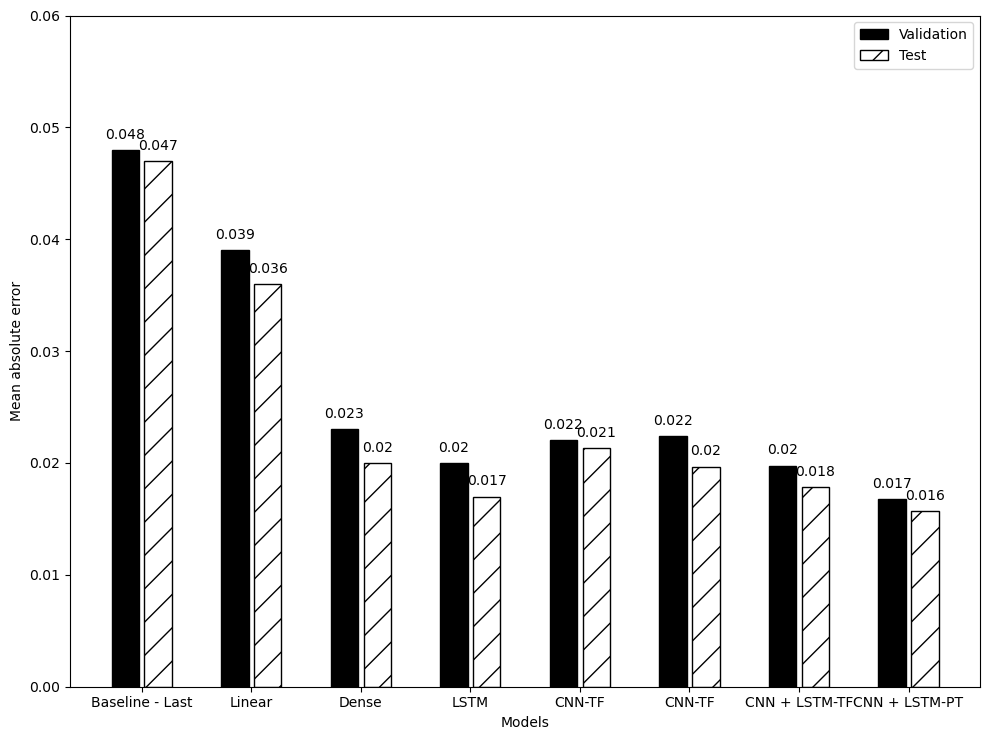

In [133]:
mo_mae_val.extend([v[1] for v in mo_val_performance.values()])
mo_mae_test.extend([v[1] for v in mo_performance.values()])

x = np.arange(8)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN-TF', 'CNN-TF', 'CNN + LSTM-TF', 'CNN + LSTM-PT']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

# Exercices

In [134]:
train_df = pd.read_csv('Data/ex_train.csv')
val_df = pd.read_csv('Data/ex_val.csv')
test_df = pd.read_csv('Data/ex_test.csv')

print(train_df.shape, val_df.shape, test_df.shape)

train_df

(13239, 12) (3783, 12) (1892, 12)


PM2.5      PM10       SO2       NO2        CO        O3      TEMP  \
0      0.128492  0.146789  0.165192  0.340278  0.191919  0.000000  0.212230   
1      0.149721  0.179409  0.179941  0.343750  0.202020  0.000000  0.194245   
2      0.154190  0.216106  0.168142  0.340278  0.222222  0.000000  0.176259   
3      0.148603  0.158002  0.185841  0.361111  0.292929  0.000000  0.176259   
4      0.144134  0.163099  0.159292  0.364583  0.292929  0.000000  0.194245   
...         ...       ...       ...       ...       ...       ...       ...   
13234  0.130726  0.119266  0.008850  0.135417  0.121212  0.109264  0.776978   
13235  0.124022  0.113150  0.020649  0.131944  0.121212  0.175772  0.802158   
13236  0.129609  0.118247  0.026549  0.128472  0.131313  0.239905  0.812950   
13237  0.135196  0.123344  0.032448  0.121528  0.131313  0.344418  0.843525   
13238  0.134078  0.122324  0.035398  0.104167  0.131313  0.479810  0.870504   

           PRES      DEWP      WSPM   day_sin   day_cos  
0      0.614679  0.296721  0.062500  0.853553  0.853553  
1      0.559633  0.344262  0.062500  0.933013  0.750000  
2      0.522936  0.318033  0.035714  0.982963  0.629410  
3      0.522936  0.370492  0.035714  1.000000  0.500000  
4      0.486239  0.301639  0.098214  0.982963  0.370590  
...         ...       ...       ...       ...       ...  
13234  0.383486  0.921311  0.160714  0.500000  0.000000  
13235  0.381651  0.921311  0.089286  0.370590  0.017037  
13236  0.377982  0.913115  0.142857  0.250000  0.066987  
13237  0.376147  0.913115  0.133929  0.146447  0.146447  
13238  0.361468  0.888525  0.178571  0.066987  0.250000  

[13239 rows x 12 columns]

In [135]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='NO2', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [136]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [137]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Single-step model

### CNN

In [138]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

conv_window = DataWindow(input_width=KERNEL_WIDTH, label_width=1, shift=1, label_columns=['NO2'])
wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['NO2'])

In [139]:
cnn_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(cnn_model, conv_window)

val_performance = {}
performance = {}

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0061 - mean_absolute_error: 0.0490 - val_loss: 0.0021 - val_mean_absolute_error: 0.0317
Epoch 2/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0019 - mean_absolute_error: 0.0299 - val_loss: 0.0019 - val_mean_absolute_error: 0.0292
Epoch 3/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0017 - mean_absolute_error: 0.0286 - val_loss: 0.0022 - val_mean_absolute_error: 0.0329
Epoch 4/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0280 - val_loss: 0.0019 - val_mean_absolute_error: 0.0288
Epoch 5/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0272 - val_loss: 0.0020 - val_mean_absolute_error: 0.0304
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 - mean_absolute_error: 0.0304  


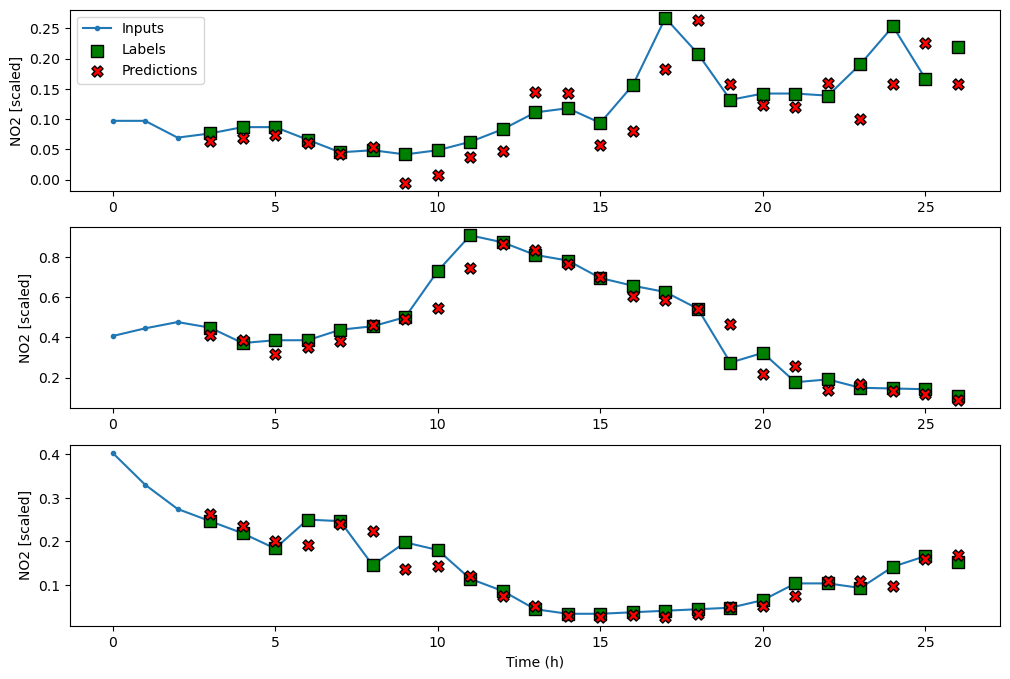

In [140]:
wide_conv_window.plot(cnn_model)

### CNN + LSTM

In [141]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0066 - mean_absolute_error: 0.0536 - val_loss: 0.0023 - val_mean_absolute_error: 0.0332
Epoch 2/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0019 - mean_absolute_error: 0.0307 - val_loss: 0.0019 - val_mean_absolute_error: 0.0290
Epoch 3/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0288 - val_loss: 0.0023 - val_mean_absolute_error: 0.0352
Epoch 4/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0018 - mean_absolute_error: 0.0287 - val_loss: 0.0018 - val_mean_absolute_error: 0.0278
Epoch 5/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0017 - mean_absolute_error: 0.0280 - val_loss: 0.0019 - val_mean_absolute_error: 0.0284
Epoch 6/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0273 - val_loss: 0.0018 - val_mean_absolute_error: 0.0271
Epoch 7/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0269 - v

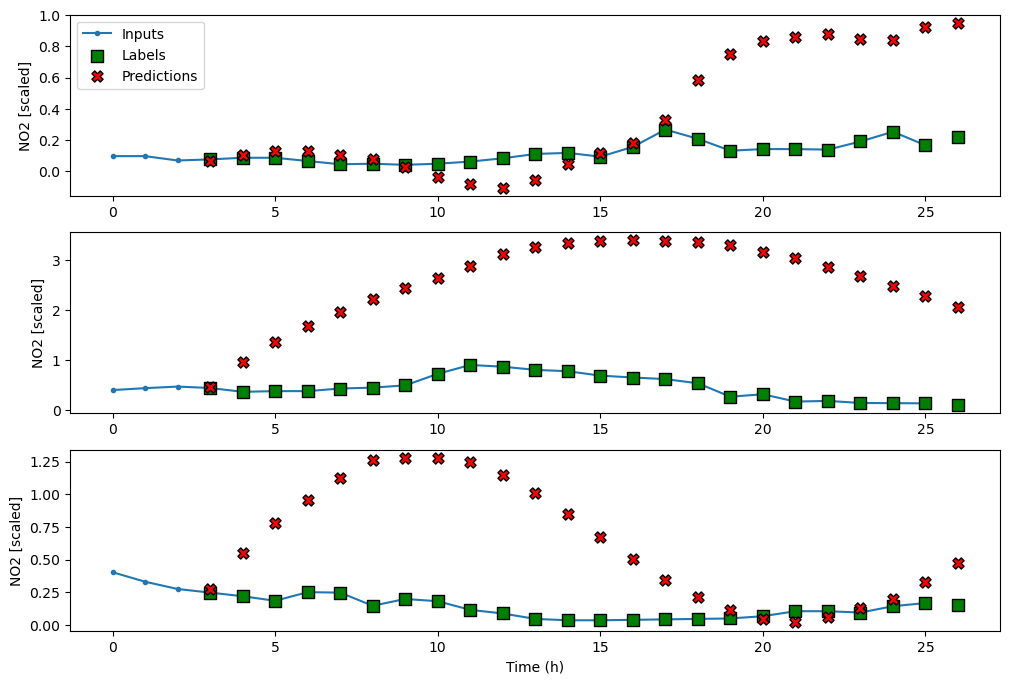

In [144]:
wide_conv_window.plot(cnn_lstm_model)

In [145]:
# Values obtained from 14

mae_val = [0.029, 0.028, 0.029, 0.027]
mae_test = [0.033, 0.032, 0.034, 0.033]

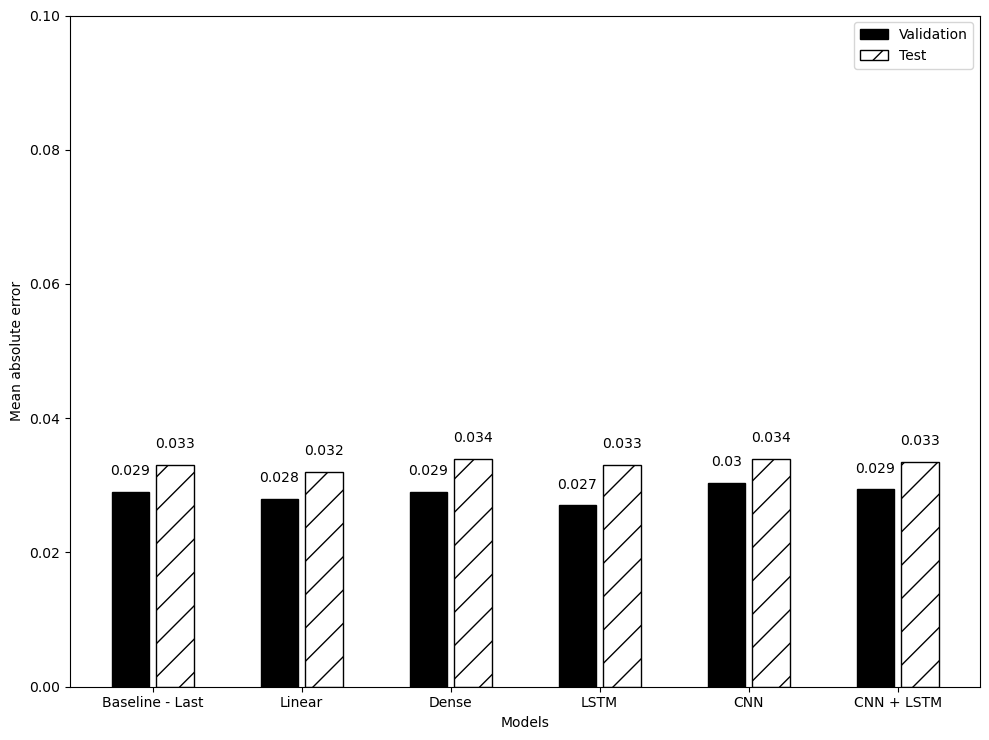

In [146]:
mae_val.extend([v[1] for v in val_performance.values()])
mae_test.extend([v[1] for v in performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

## Multi-step model

### CNN

In [147]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['NO2'])

In [148]:
ms_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_model, multi_conv_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_conv_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_conv_window.test, verbose=0)

Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0132 - mean_absolute_error: 0.0871 - val_loss: 0.0083 - val_mean_absolute_error: 0.0689
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0111 - mean_absolute_error: 0.0800 - val_loss: 0.0084 - val_mean_absolute_error: 0.0680
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108 - mean_absolute_error: 0.0785 - val_loss: 0.0082 - val_mean_absolute_error: 0.0674
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0106 - mean_absolute_error: 0.0778 - val_loss: 0.0082 - val_mean_absolute_error: 0.0676
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0105 - mean_absolute_error: 0.0771 - val_loss: 0.0083 - val_mean_absolute_error: 0.0676
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0104 - mean_absolute_error: 0.0767 - val_loss: 0.0083 - val_mean_absolute_error: 0.0682
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0083 - mean_absolute_error: 0.0682


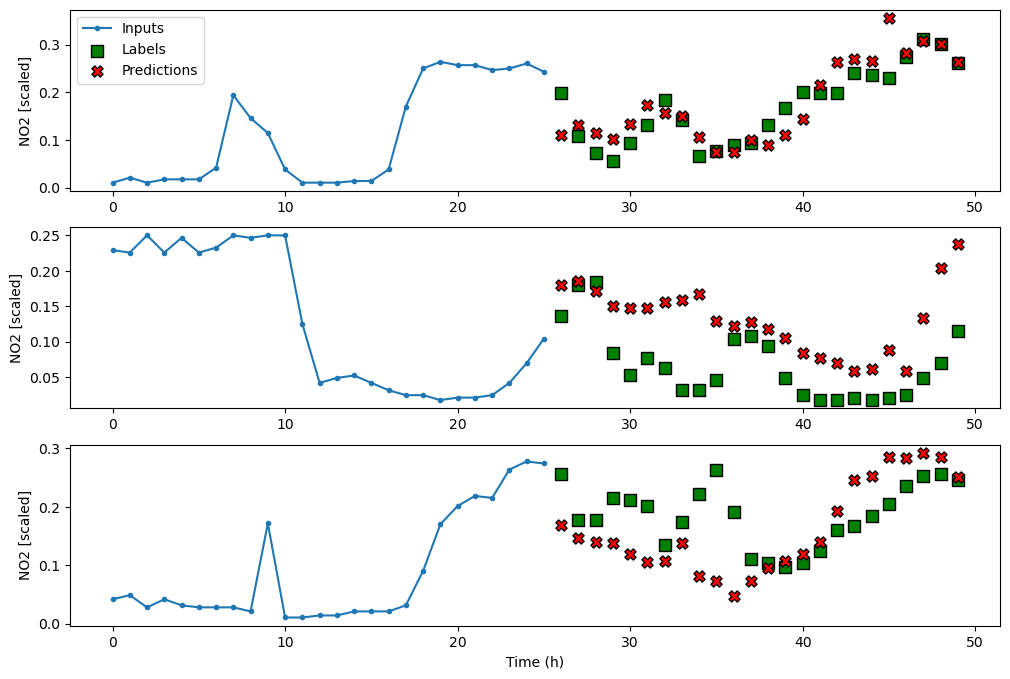

In [149]:
multi_conv_window.plot(ms_cnn_model)

### CNN + LSTM

In [150]:
ms_cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_lstm_model, multi_conv_window)

ms_val_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_conv_window.val)
ms_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_conv_window.test, verbose=0)

Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0137 - mean_absolute_error: 0.0888 - val_loss: 0.0084 - val_mean_absolute_error: 0.0691
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0113 - mean_absolute_error: 0.0805 - val_loss: 0.0083 - val_mean_absolute_error: 0.0688
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0108 - mean_absolute_error: 0.0787 - val_loss: 0.0085 - val_mean_absolute_error: 0.0688
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0106 - mean_absolute_error: 0.0781 - val_loss: 0.0090 - val_mean_absolute_error: 0.0701
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0104 - mean_absolute_error: 0.0772 - val_loss: 0.0089 - val_mean_absolute_error: 0.0697
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089 - mean_absolute_error: 0.0697


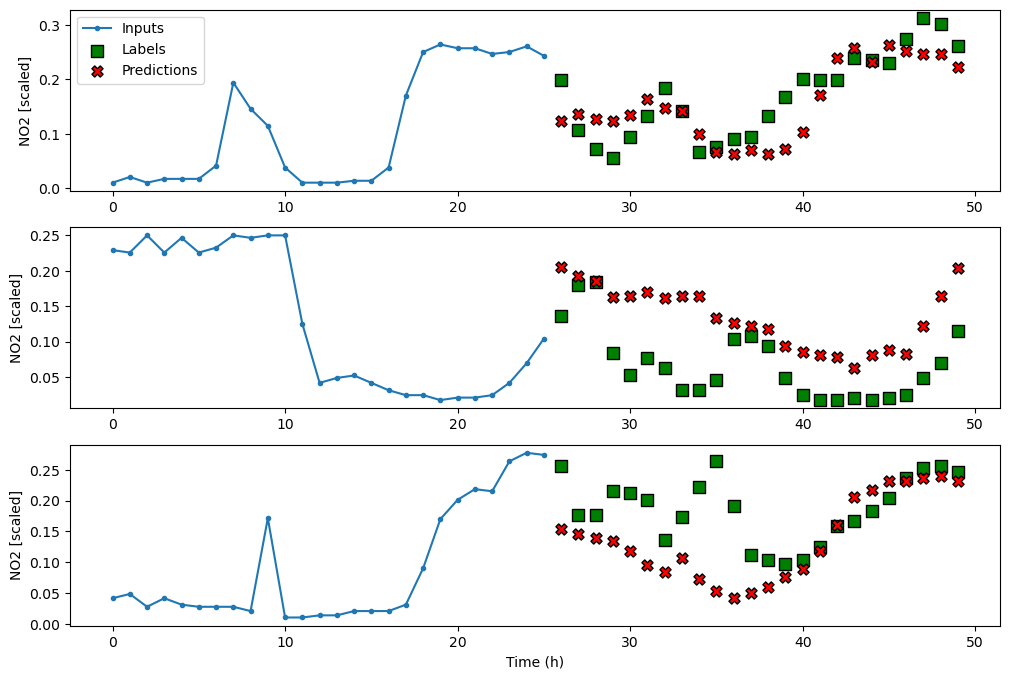

In [151]:
multi_conv_window.plot(ms_cnn_lstm_model)

In [152]:
# Values obtained from 14

ms_mae_val = [0.282, 0.282, 0.070, 0.071, 0.069]
ms_mae_test = [0.243, 0.244, 0.115, 0.114, 0.114]

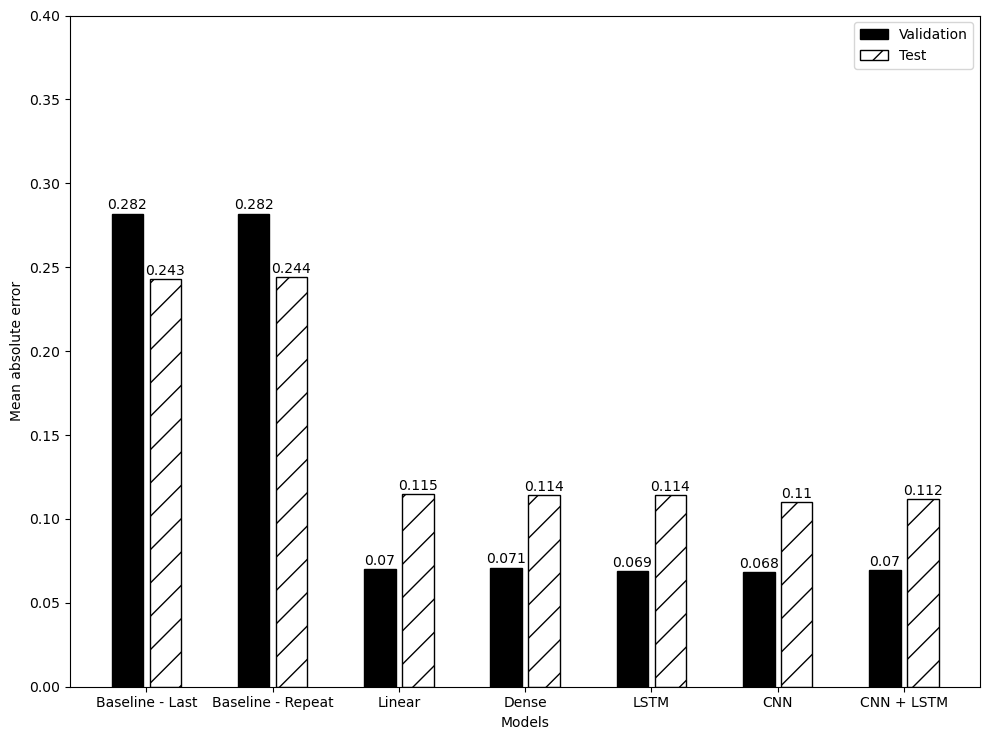

In [153]:
ms_mae_val.extend([v[1] for v in ms_val_performance.values()])
ms_mae_test.extend([v[1] for v in ms_performance.values()])

x = np.arange(7)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

## Multi-output model

### CNN

In [154]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_mo_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=24, shift=1, label_columns=['NO2', 'TEMP'])

In [155]:
mo_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_model, wide_mo_conv_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0051 - mean_absolute_error: 0.0431 - val_loss: 0.0013 - val_mean_absolute_error: 0.0237
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011 - mean_absolute_error: 0.0225 - val_loss: 0.0012 - val_mean_absolute_error: 0.0218
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.9530e-04 - mean_absolute_error: 0.0210 - val_loss: 0.0011 - val_mean_absolute_error: 0.0208
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.3475e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0012 - val_mean_absolute_error: 0.0218
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.0116e-04 - mean_absolute_error: 0.0194 - val_loss: 0.0011 - val_mean_absolute_error: 0.0203
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.7867e-04 - mean_absolute_error: 0.0190 - val_loss: 0.0010 - val_mean_absolute_error: 0.0193
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.6641e-04 - mean_absolu

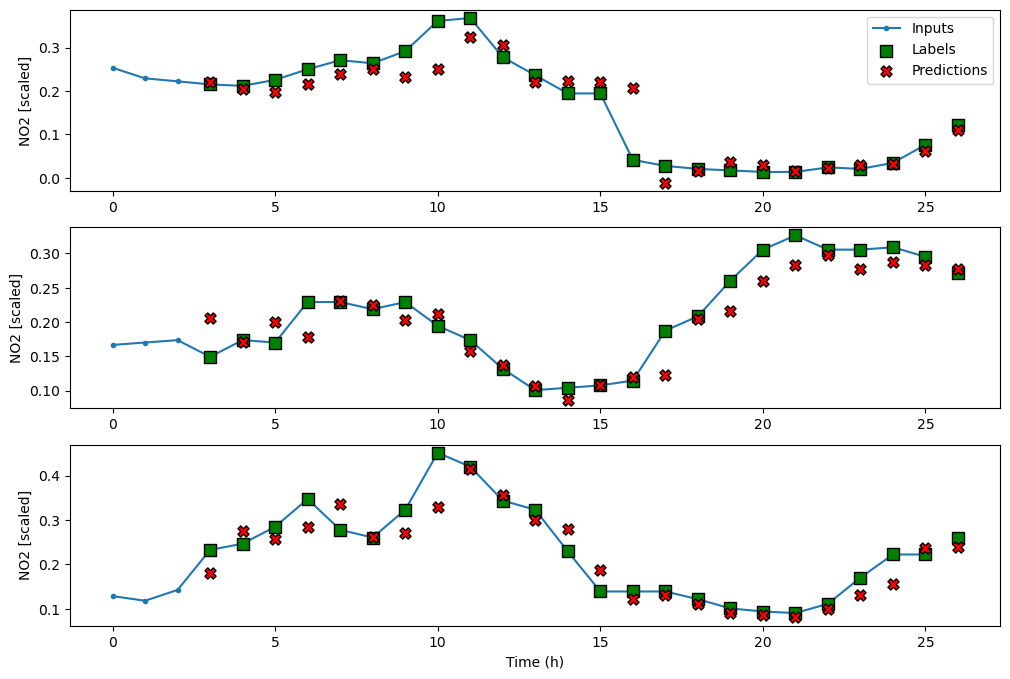

In [156]:
wide_mo_conv_window.plot(mo_cnn_model)

### CNN + LSTM

In [157]:
mo_cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_lstm_model, wide_mo_conv_window)

mo_val_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0108 - mean_absolute_error: 0.0632 - val_loss: 0.0022 - val_mean_absolute_error: 0.0337
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0016 - mean_absolute_error: 0.0289 - val_loss: 0.0013 - val_mean_absolute_error: 0.0250
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0012 - mean_absolute_error: 0.0238 - val_loss: 0.0012 - val_mean_absolute_error: 0.0231
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0011 - mean_absolute_error: 0.0220 - val_loss: 0.0011 - val_mean_absolute_error: 0.0218
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.9909e-04 - mean_absolute_error: 0.0211 - val_loss: 0.0011 - val_mean_absolute_error: 0.0211
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.6067e-04 - mean_absolute_error: 0.0204 - val_loss: 0.0011 - val_mean_absolute_error: 0.0210
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.3405e-04 - mean_absolute_error

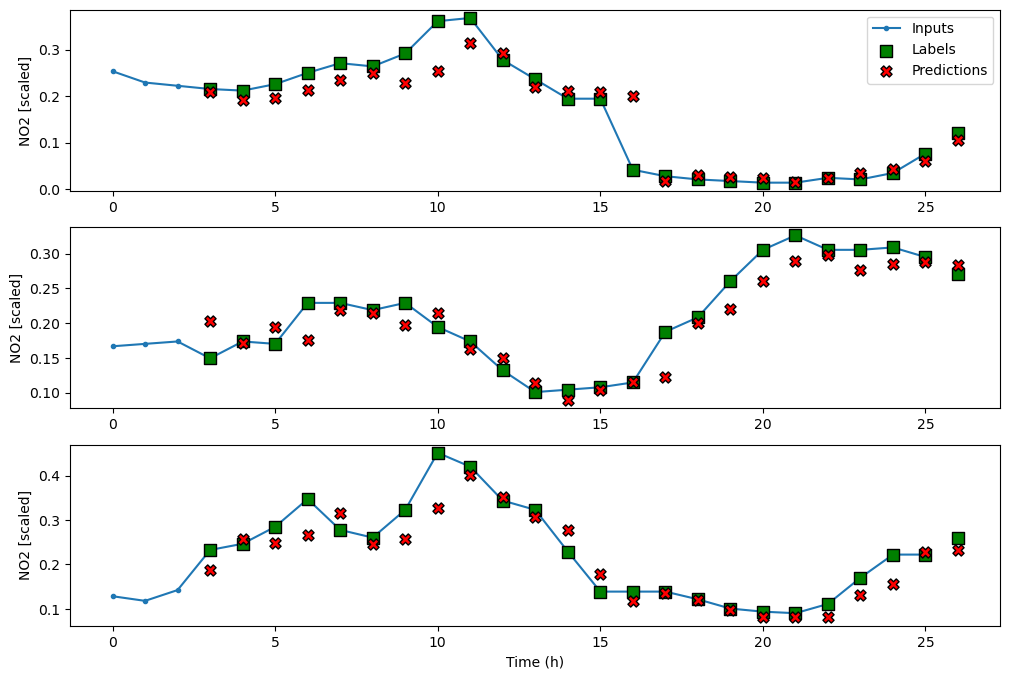

In [158]:
wide_mo_conv_window.plot(mo_cnn_lstm_model)

In [159]:
# Values from 14

mo_mae_val = [0.021, 0.020, 0.020, 0.019]
mo_mae_test = [0.025, 0.023, 0.025, 0.022]

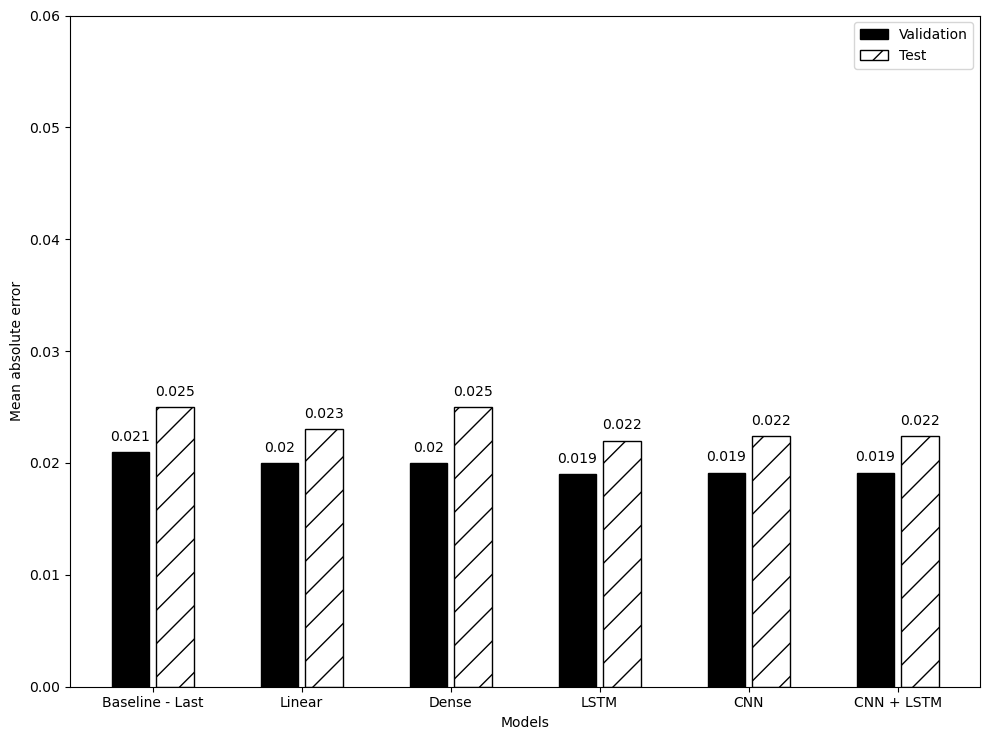

In [160]:
mo_mae_val.extend([v[1] for v in mo_val_performance.values()])
mo_mae_test.extend([v[1] for v in mo_performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

In [161]:
# Summary

# The convolutional neural network (CNN) is a deep learning architecture that
# makes use of the convolution operation.

# The convolution operation is performed between a kernel and the feature
# space. It is simply the dot product between the kernel and the feature vector.

# Running a convolution operation results in an output sequence that is shorter
# than the input sequence. Running many convolutions can therefore decrease
# the output length quickly. Padding can be used to prevent that. 
 
# In time series forecasting, the convolution is performed in one dimension only:
# the temporal dimension. 

# The CNN is just another model in your toolbox and may not always be the best
# performing model. Make sure you window your data correctly with DataWindow,
# and keep your testing methodology valid by keeping each set of data constant,
# building baseline models, and evaluating all models with the same error metric.